In [1]:
import numpy as np
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
from cmath import sqrt


In [13]:
def plot_single_tuning_curve(cell_dictionary,cell_ID):

    fig = plt.figure(1)
    fig.set_facecolor('white')
    ax = fig.gca()
    ax.set_facecolor('white')

    # frequency_labels = [5.7,23,45] #,52]
    # intensity_labels = [0,70,80,90] #[50,70,90]

    frequency_labels = [4.4,6.6,10,16,23,34]
    # # intensity_labels = [30,50,70]
    intensity_labels = [30,50,70,90]

    # frequency_labels = [4,8,12,23,45]
    # # intensity_labels = [30,50,70]
    # intensity_labels = [0,40,60,80]

    # get cell ID at this index so we can pull its tuning curve
    # cell_IDs = list(cell_dictionary.keys())
    # cell_of_interest_ID = cell_IDs[cell_IDX]

    cell_tuning = cell_dictionary[cell_ID]['tuning_curve_peak']

    im = plt.imshow(np.transpose(cell_tuning),cmap='winter',origin='lower')
    plt.colorbar(im)
    # plt.xticks([0,1,2])
    # ax.set_xticklabels(frequency_labels)
    # plt.yticks([0,1,2,3])
    # ax.set_yticklabels(intensity_labels)
    plt.xticks([0,2,4,6,8,10])
    ax.set_xticklabels(frequency_labels)
    plt.yticks([0,1,2,3])
    ax.set_yticklabels(intensity_labels)
    ax.set_ylabel("Intensity (dB)")
    ax.set_xlabel("Frequency (Hz)")
    # plt.xticks([0,1,2,3,4])
    # ax.set_xticklabels(frequency_labels)
    # plt.yticks([0,1,2,3])
    # ax.set_yticklabels(intensity_labels)
    plt.show()

In [17]:
def get_cell_tuning_by_peak(cell_traces,plot_TF):

    if plot_TF:
        fig = plt.figure(figsize=(12,8), dpi=100)
        fig,axs = plt.subplots(4,12,sharex='col',sharey='row',figsize=(14,5))
        # axs = axs.ravel()

    EPOCH_START_IN_MS = -500
    FRAMERATE = 10

    # cell_traces is a dictionary of frequencies 
    # under each frequency is a dictionary of intensities
    # under each intensity are the traces for each repetitiong of that frequency/intensity combination

    # allocate some space to return
    # we want a matrix that is nFrequencies x nIntensities 
    tuning_curves = np.empty((len(cell_traces),len(cell_traces[next(iter(cell_traces))].keys())))

    n_baseline_frames = round(EPOCH_START_IN_MS/1000 * FRAMERATE)*-1

    plot_coln_counter = 0
    frequency_counter = 0 # to keep track of where we're indexing the empty array
    for freq in cell_traces:
        intensity_counter = 0

        # find the number of intensities we presented at
        n_intensities = len(cell_traces[freq].keys())

        # make a temporary vector to append to the tuning curve at the end of this loop
        # we will fill one n_intensities length column of the 2D matrix we are returning
        activation_per_intensity = np.empty((n_intensities,1))

        # iterate through each intensity the frequency was presented at
        plot_row_counter = 0
        for intensity in cell_traces[freq]:
            # collect all the trials of this one frequency presented at this one intensity
            # it will be an nTrials x nFrames matrix
            all_trials_of_this_intensity = []
            n_baseline_frames = round(EPOCH_START_IN_MS/1000 * FRAMERATE)*-1
            # iterate through each trial of this frequency/intensity combination
            counter=0
            for trial in cell_traces[freq][intensity]:
                
                # if plot_TF:
                #     plt.plot(cell_traces[freq][intensity][trial][n_baseline_frames:])

                counter+=1
                trace = cell_traces[freq][intensity][trial]
                # print(trace)
                # input()
                # baseline = trace[0:n_baseline_frames]
                # baseline_mean = np.average(baseline)
                # baseline_std = np.std(baseline)

                # zscorer = lambda x: (x-baseline_mean)/baseline_std

                # response = trace[n_baseline_frames:]
                # zscore_response = np.array([zscorer(xi) for xi in response])
                all_trials_of_this_intensity.append(trace)

            # plt.show()

            # convert the matrix of trials into a np array
            all_trials_as_np = np.array(all_trials_of_this_intensity)

            # average across all the trials to get a 1 x nFrames vector
            average_trial_of_this_intensity = np.average(all_trials_as_np, axis=0)

            # now we grab the peak of the trace occuring AFTER the onset
            
            # baseline = average_trial_of_this_intensity[0:n_baseline_frames]
            # baseline_mean = np.average(baseline)
            # baseline_std = np.std(baseline)

            # zscorer = lambda x: (x-baseline_mean)/baseline_std

            # response = average_trial_of_this_intensity[n_baseline_frames:]
            # zscore_response = np.array([zscorer(xi) for xi in response])
            response = average_trial_of_this_intensity[n_baseline_frames:]

            if plot_TF:
                error = []
                for timepoint in range(len(all_trials_as_np[0])):
                    if timepoint<n_baseline_frames:
                        continue

                    timepoint_std = np.std(all_trials_as_np[:,timepoint])
                    timepoint_se = timepoint_std/sqrt(len(all_trials_as_np[:,timepoint]))
                    error.append(timepoint_se)

            if plot_TF:
                # print(len(error))
                # print(len(response))
                axs[3-plot_row_counter,plot_coln_counter].plot(np.transpose(all_trials_as_np))
                axs[3-plot_row_counter,plot_coln_counter].axvline(x=4,color='k',linestyle='--')
                # axs[plot_row_counter,plot_coln_counter].plot(response)
                # axs[plot_row_counter,plot_coln_counter].fill_between(range(len(response)),response-error,response+error,alpha=0.5)
                axs[3-plot_row_counter,plot_coln_counter].xaxis.set_visible(False)
                axs[3-plot_row_counter,plot_coln_counter].yaxis.set_visible(False)
                axs[3-plot_row_counter,plot_coln_counter].set_ylim(bottom=0,top=2000)
                axs[3-plot_row_counter,plot_coln_counter].autoscale(enable=True, axis='x', tight=True)
                # axs[3-plot_row_counter,plot_coln_counter].title.set_text(intensity)
                # axs[plot_row_counter,plot_coln_counter].title.set_text(intensity)
                # axs[5-plot_row_counter,plot_coln_counter].text(10,300,str(intensity))

            # zscore_response = zscore(response)
            peak_response = np.amax(response)
            # peak_response = np.amax(response)
            # peak_response = np.trapz(response)
            tuning_curves[frequency_counter,intensity_counter] = peak_response

            intensity_counter += 1
            # print(freq)
            # print(intensity)
            plot_row_counter += 1

        plot_coln_counter += 1
        frequency_counter += 1
    
    if plot_TF:
        fig.subplots_adjust(wspace=0,hspace=0)
        plt.show()
    return tuning_curves

In [21]:
with open('/media/vtarka/USB DISK/Lab/2P/Vid_220/cells_ns.pkl', 'rb') as f:
        cell_dictionary = pickle.load(f)


In [5]:
print(cell_dictionary[1].keys())

dict_keys(['traces', 'active', 'tuning_curve_peak', 'x', 'y'])


In [6]:
for cell in cell_dictionary:
    if cell_dictionary[cell]['active']:
        print(cell)

1
5
12
13
15
16
17
19
23
37
49
50
53
62
63
68
69
73
76
87
88
95
99
106
109
113
114
118
123
128
129
134
136
139
144
148
149
157
164
170
174
176
178
182
186
220
221
226
290
296
317
319
355
371
377
410
431
535
549
646
704
744
761
817
964
993
1007
1208


True


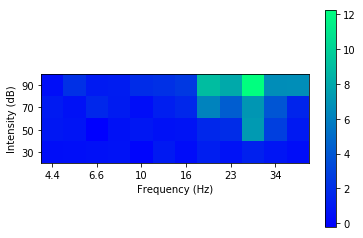

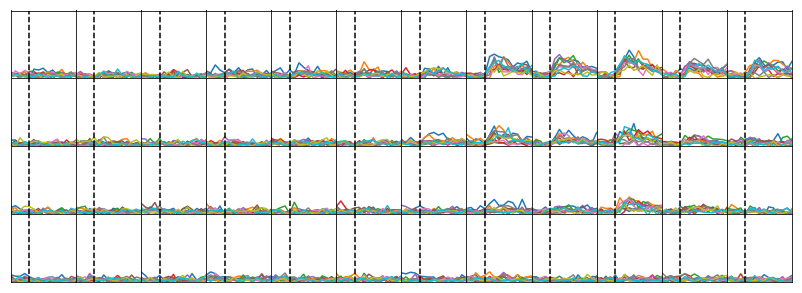

array([[ 89.94719543, 106.47010345,  93.61543274, 127.00004501],
       [ 91.01914673, 108.68030167, 111.19291916, 135.88999634],
       [ 92.7370163 , 104.92065887, 127.57817535, 104.5227623 ],
       [118.99709778, 117.93836365, 104.72606125, 145.8180191 ],
       [ 89.86817245, 116.51957245, 119.40286636, 203.5384903 ],
       [119.23676224, 122.26054153, 138.15138397, 193.64284897],
       [ 96.50855942, 108.99125977, 167.43147583, 203.22902374],
       [149.75820007, 158.86364441, 326.4331665 , 471.81527252],
       [ 97.34531631, 159.91719513, 233.66633301, 413.62555084],
       [125.29044952, 311.99334412, 310.8916748 , 534.3591156 ],
       [116.84597015, 169.27009583, 201.37890549, 380.99541931],
       [ 89.32301712, 112.68745651, 166.82571869, 365.27243958]])

In [30]:

cell_ID = 855
print(cell_dictionary[cell_ID]['active'])
plot_single_tuning_curve(cell_dictionary,cell_ID)
get_cell_tuning_by_peak(cell_dictionary[cell_ID]['traces'],True)

